**Task:** genre classification based on audio data.
**Goal:** compare different approaches to audio data modeling:
- feature engineering + ML,
- plotting + Computer Vision,
- embeddings + Transformers.

Full Text: [Music Information Retrieval: Modeling Audio Data](https://medium.com/@kate.ruksha/music-information-retrieval-modeling-audio-data-9dd0321d7e93)

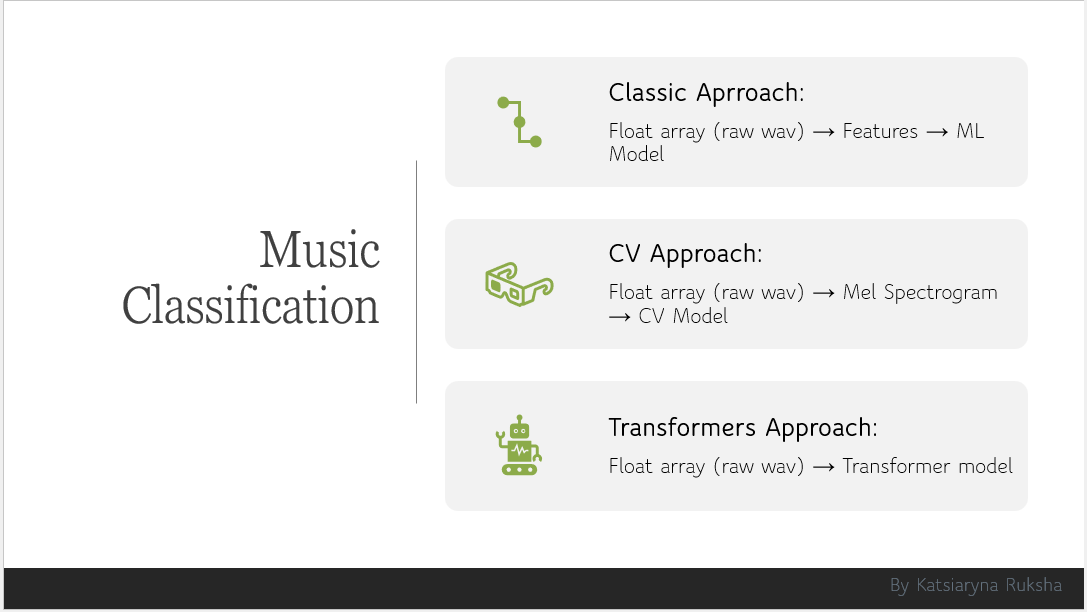

# Setup

In [6]:
!pip install tensorflow

In [7]:
! pip install -q gradio transformers datasets[audio] accelerate evaluate wandb torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168

In [8]:
from warnings import filterwarnings
filterwarnings('ignore')

import re
import os
import scipy
import shutil
import IPython
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
from scipy.io.wavfile import write, read
from sklearn.preprocessing import LabelEncoder, StandardScaler

import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential


# import computer vision libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0

# Import for transformers
import wandb
import evaluate
import torchaudio
# from datasets import load_dataset
# from datasets import Audio
from datasets import Dataset
from transformers import AutoFeatureExtractor
# from huggingface_hub import notebook_login, login
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import pipeline
from transformers import Trainer

In [9]:
# get data from kaggle
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
! unzip gtzan-dataset-music-genre-classification.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:56<00:00, 24.1MB/s]
100% 1.21G/1.21G [00:56<00:00, 23.1MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflatin

In [ ]:
# Make a list of all the wav files in the dataset
audio_files = glob("Data/genres_original/*/*.wav")
print(len(audio_files))

1000


# Classic ML approach

Generate features and train a model.
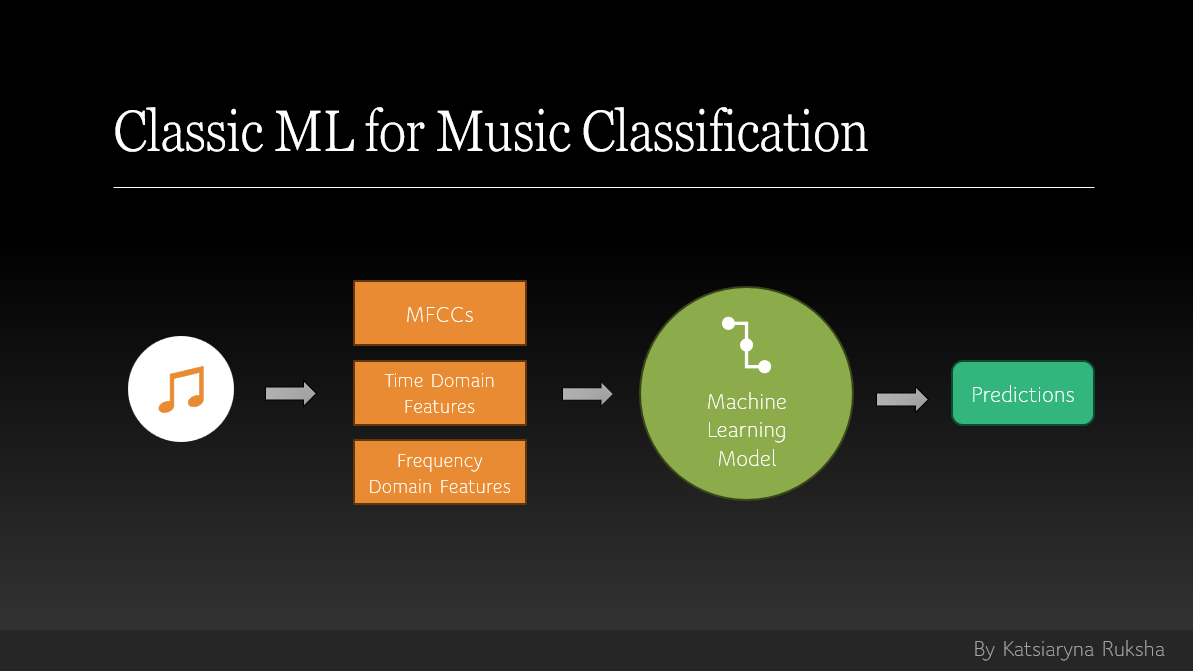

## Feature generation

In [ ]:
def amplitude_envelope(signal, frame_size, hop_length):
    """Function for calculating the amplitude envelope"""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

In [ ]:
def feature_generation(path = "Data/genres_original/",):

    audio_files = glob(path + "*/*.wav")

    N_MFCC = 20
    HOP_SIZE = 512
    FRAME_SIZE = 1024
    N_FFT = 2048

    dataset = pd.DataFrame()

    for i in range(len(audio_files)):

        try:
            y, sampling_rate = librosa.load(audio_files[i])
        except:
            print("Error while reading ", audio_files[i])
            pass
        dataset.loc[i, 'filename'] = audio_files[i]
        dataset.loc[i, 'label'] = re.sub(r'\/.*', "", audio_files[i].replace(path, ""))
        dataset.loc[i, 'length'] = int(y.shape[0])

        # Tempo
        onset_env = librosa.onset.onset_strength(y=y, sr=sampling_rate)
        tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sampling_rate)
        dataset.loc[i, "tempo"] = tempo

        # Amplitude envelope
        ae = amplitude_envelope(signal=y, hop_length=HOP_SIZE, frame_size=FRAME_SIZE)

        # Root mean square energy
        rms = librosa.feature.rms(y=y, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        dataset.loc[i, "rms_mean"] = rms.mean()
        dataset.loc[i, "rms_var"] = rms.var()

        # Zero crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y = y,hop_length = HOP_SIZE)[0]
        dataset.loc[i, "zero_crossing_rate_mean"] = zero_crossing_rate.mean()
        dataset.loc[i, "zero_crossing_rate_var"] = zero_crossing_rate.var()

        # Spectral centroid
        centroid = librosa.feature.spectral_centroid(y=y)
        dataset.loc[i, "spectral_centroid_mean"] = centroid.mean()
        dataset.loc[i, "spectral_centroid_var"] = centroid.var()

        # Spectral bandwidth
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sampling_rate)
        dataset.loc[i, "spectral_bandwidth_mean"] = spec_bw.mean()
        dataset.loc[i, "spectral_bandwidth_var"] = spec_bw.var()

        # Spectral roll-off
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sampling_rate)
        dataset.loc[i, "rolloff_mean"] = rolloff.mean()
        dataset.loc[i, "rolloff_var"] = rolloff.var()

        # Harmonic and percussive
        D = librosa.stft(y)
        D_harmonic, D_percussive = librosa.decompose.hpss(D)
        dataset.loc[i, "harmony_mean"] = D_harmonic.mean()
        dataset.loc[i, "harmony_var"] = D_harmonic.var()
        dataset.loc[i, "perceptr_mean"] = D_percussive.mean()
        dataset.loc[i, "perceptr_var"] = D_percussive.var()

        # Chromagram
        chromagram = librosa.feature.chroma_stft(y=y, sr=sampling_rate, hop_length=HOP_SIZE)
        dataset.loc[i, "chroma_stft_mean"] = chromagram.mean()
        dataset.loc[i, "chroma_stft_var"] = chromagram.var()

        # MFCCs
        mfcc_data = librosa.feature.mfcc(y=y, sr = sampling_rate, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_SIZE)
        mfcc_data=mfcc_data.T
        for x in range(N_MFCC):
            dataset.loc[i, "mfcc" + str(x+1) + "_mean"] = (mfcc_data[:,x].mean())
            dataset.loc[i, "mfcc" + str(x+1) + "_var"] = (mfcc_data[:,x].var())

    return dataset

In [ ]:
dataset = feature_generation()

<ipython-input-25-6e7f3b927ca3>:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '(0.00017598614795133471+9.24764208320994e-06j)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[i, "harmony_mean"] = D_harmonic.mean()
<ipython-input-25-6e7f3b927ca3>:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '(-0.0008824231917969882-7.913391527836211e-06j)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[i, "perceptr_mean"] = D_percussive.mean()
<ipython-input-25-6e7f3b927ca3>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sampling_rate = librosa.load(audio_files[i])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It

Error while reading  Data/genres_original/jazz/jazz.00054.wav


In [ ]:
dataset.head()

,filename,label,length,tempo,rms_mean,rms_var,zero_crossing_rate_mean,zero_crossing_rate_var,spectral_centroid_mean,spectral_centroid_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,Data/genres_original/disco/disco.00012.wav,disco,663520.0,112.347147,0.172282,0.004836,0.131499,0.003875,2737.358915,488208.414595,...,2.989989,79.111061,2.904680,77.962334,4.023067,88.383972,0.523169,61.120323,1.953289,66.484718
1,Data/genres_original/disco/disco.00037.wav,disco,661794.0,129.199219,0.159967,0.004943,0.190011,0.005141,3637.157092,486690.606238,...,-1.085848,40.131672,-0.672644,30.133274,2.392190,50.781178,4.168654,50.024578,2.862442,49.630337
2,Data/genres_original/disco/disco.00054.wav,disco,661504.0,112.347147,0.049877,0.000898,0.114603,0.005568,2565.721388,825413.462615,...,3.321342,65.792862,-11.270045,70.920181,1.389739,87.927544,-10.697609,76.996765,-4.334098,63.369484
3,Data/genres_original/disco/disco.00033.wav,disco,661794.0,129.199219,0.155939,0.001348,0.124487,0.001664,2450.056641,407962.922653,...,3.446969,48.200314,0.134570,54.551552,-0.946985,55.948021,-2.636542,55.197891,1.644716,67.457726
4,Data/genres_original/disco/disco.00029.wav,disco,661794.0,103.359375,0.143761,0.004291,0.138536,0.002495,3075.024488,384331.193595,...,-6.403064,68.542404,0.457799,77.071312,-2.272158,94.182663,2.983864,108.488632,-0.031934,106.967316


In [ ]:
dataset.to_pickle('features_30.pkl')

## Preprocessing

In [2]:
dataset = pd.read_pickle('features_30.pkl')

In [ ]:
y = dataset['label']
X_df = dataset.drop(['filename', 'label'], axis=1)
complex_cols = [col for col in X_df.columns if X_df[col].dtype == 'object' and any(isinstance(x, str) and 'j' in x for x in X_df[col])]

for col in complex_cols:
    X_df[col] = X_df[col].apply(lambda x: complex(x) if isinstance(x, str) and 'j' in x else x)
X = np.array(X_df, dtype=float)

# split data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
filenames = dataset['filename']
filenames_train, filenames_test, _, _ = train_test_split(filenames, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
encoder = LabelEncoder().fit(y_train)
scaler = StandardScaler().fit(X_train)

x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

## ML models

In [ ]:
# create an instance of each classification algorithm

LR=LogisticRegression()
KN=KNeighborsClassifier()
D=DecisionTreeClassifier()
RF=RandomForestClassifier()

XGB=XGBClassifier()
LGBM = lgb.LGBMClassifier(objective='multiclass',
                             verbose=-1,
                             random_state=101,
                             verbose_eval=False)

algos=[LR,KN,D,RF, XGB, LGBM]
algo_names=['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier', 'XGBClassifier', 'LightGBM']

accuracy_scored=[]
for item in algos:
    item.fit(x_train,y_train)
    item.predict(x_test)
    accuracy_scored.append(accuracy_score(y_test,item.predict(x_test)))

In [ ]:
# show results in a DataFrame
result = pd.DataFrame(accuracy_scored, columns=["Accuracy"])
result['Algos']=algo_names
result.sort_values('Accuracy',ascending=False)

,Accuracy,Algos
5,0.790909,LightGBM
3,0.778788,RandomForestClassifier
4,0.769697,XGBClassifier
0,0.730303,LogisticRegression
1,0.690909,KNeighborsClassifier
2,0.560606,DecisionTreeClassifier


## DNN model

In [ ]:
tf.random.set_seed(221)
model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 512)                 │          30,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 587,168 (2.24 MB)

 Trainable params: 195,722 (764.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 391,446 (1.49 MB)

In [ ]:
tf.random.set_seed(221)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=32)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2496 - loss: 2.0959 - val_accuracy: 0.4576 - val_loss: 1.4630
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5181 - loss: 1.3373 - val_accuracy: 0.5848 - val_loss: 1.1300
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6318 - loss: 1.0400 - val_accuracy: 0.6667 - val_loss: 0.9882
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7156 - loss: 0.8384 - val_accuracy: 0.7152 - val_loss: 0.8699
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7620 - loss: 0.7053 - val_accuracy: 0.7424 - val_loss: 0.7725
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7852 - loss: 0.6122 - val_accuracy: 0.7636 - val_loss: 0.7504
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8264 - loss: 0.5237 - val_accuracy: 0.7424 - val_loss: 0.7368
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8520 - loss: 0.4417 - val_accuracy: 0.7333 - v

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7772 - loss: 0.8185 
Accuracy: 0.7696969509124756


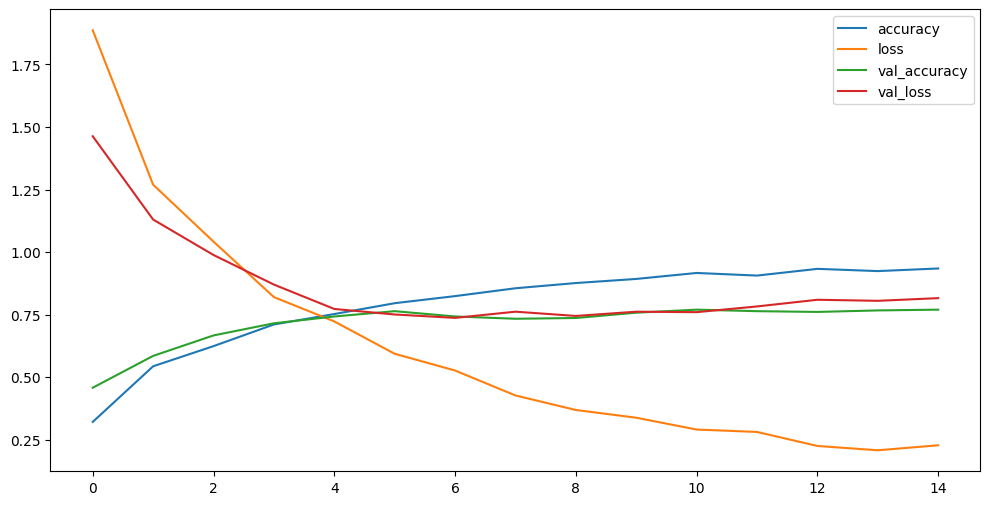

In [ ]:
_, accuracy = model.evaluate(x_test, y_test, batch_size=64)
print("Accuracy:",accuracy)
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [ ]:
result.loc[len(result)] = {'Algos': 'NeuralNetwork', 'Accuracy': accuracy}

# Computer Vision
Create Mel spectorgrams for audio files and apply computer vision models.
Code tries to replicate [this Kaggle post](https://www.kaggle.com/code/tranctan96/tensorflow-cnn-efficientnet-78-val-acc) where accuracy of 0.78 was claimed to be achieved.
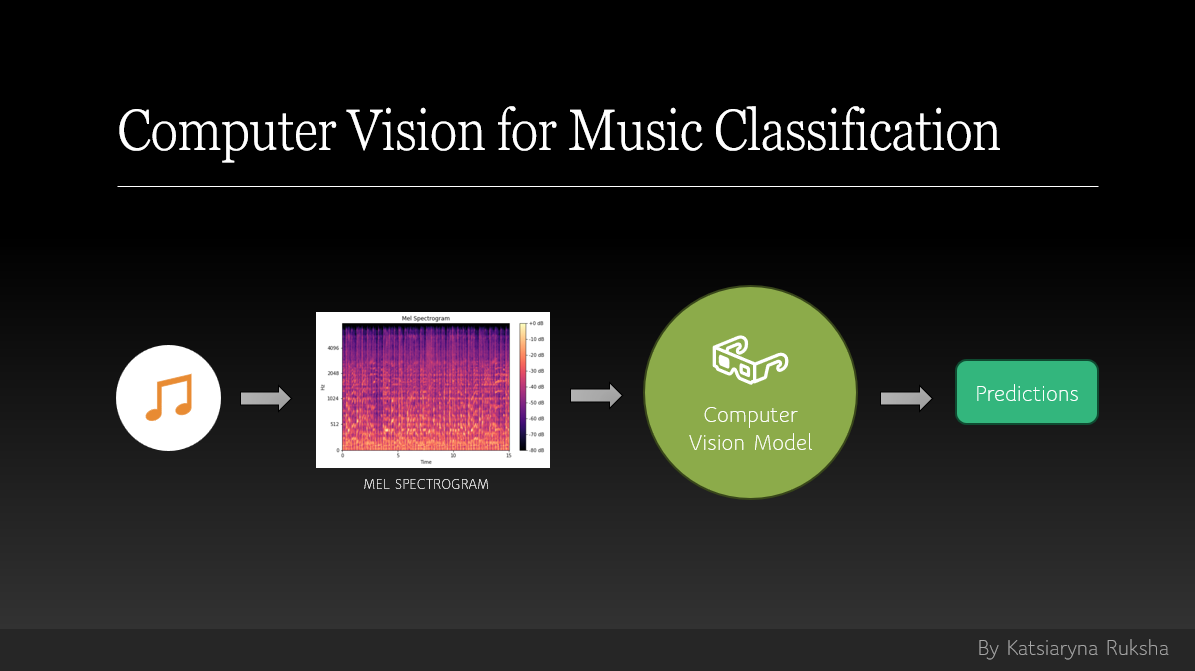

In [12]:
NUM_CLASSES = 10
BATCH_SIZE=8
TARGET_SIZE=224

train_path = "Data/training_set/"
valid_path = "Data/validation_set/"

epochs = 5

model_save_location = "Data/EfficientNet"

In [13]:
!mkdir Data/training_set/
!mkdir Data/validation_set/

In [14]:
# Example list of file paths with .wav files
file_paths = [
    'Data/genres_original/disco/disco.00012.wav',
    'Data/genres_original/classical/classical.00003.wav',
    'Data/genres_original/rock/rock.00007.wav'
]

# Function to change the file path
def convert_audio_to_image_paths(file_path):

        # Replace 'genres_original' with 'images_original'
    new_path = file_path.replace('genres_original', 'images_original')

    # Remove the period in the filename (e.g., disco.00012.wav -> disco00012.png)
    # Split the filename from the extension
    base_name = os.path.basename(new_path)  # Get 'disco.00012.wav'
    genre = os.path.dirname(new_path).split('/')[-1]  # Get genre name like 'disco'

        # Split the filename and extension
    name_no_ext, extension = base_name.rsplit('.', 1)  # Split 'disco.00012' from 'wav'

        # Now split the name on the first period to get the genre and the file number
    if '.' in name_no_ext:
        genre_name, file_number = name_no_ext.split('.', 1)
    else:
        genre_name = name_no_ext
        file_number = '00000'  # Fallback in case there's no number

        # Create the new file name without a period and change extension to .png
    new_file_name = f"{genre_name}{file_number}.png"

        # Join the new file name with the directory to form the new path
    new_dir = os.path.dirname(new_path)
    new_path = os.path.join(new_dir, new_file_name)


    return new_path

# Convert the list of file paths
convert_audio_to_image_paths(file_paths[0])


'Data/images_original/disco/disco00012.png'

In [15]:
# Get training data
file_paths = filenames_train
destination_base_dir = 'Data/training_set/'

for file_path in file_paths:
    # Extract the genre name from the path (e.g., 'disco' from 'Data/genres_original/disco/disco.00012.wav')
    genre = file_path.split('/')[-2]

    # Change the file_path from 'Data/genres_original/disco/disco.00012.wav' to 'Data/images_original/disco/disco00012.png'
    file_path = convert_audio_to_image_paths(file_path)
    genre_dir = os.path.join(destination_base_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    destination_file_path = os.path.join(genre_dir, os.path.basename(file_path))

    # Copy the file to the destination directory
    try:
        shutil.copy(file_path, destination_file_path)
    except:
        print(file_path)


Data/images_original/jazz/jazz00054.png


In [16]:
# Get validation data

file_paths = filenames_test
destination_base_dir = 'Data/validation_set/'

for file_path in file_paths:
    # Extract the genre name from the path (e.g., 'disco' from 'Data/genres_original/disco/disco.00012.wav')
    genre = file_path.split('/')[-2]

    # Change the file_path from 'Data/genres_original/disco/disco.00012.wav' to 'Data/images_original/disco/disco00012.png'
    file_path = convert_audio_to_image_paths(file_path)
    genre_dir = os.path.join(destination_base_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    destination_file_path = os.path.join(genre_dir, os.path.basename(file_path))

    # Copy the file to the destination directory
    try:
        shutil.copy(file_path, destination_file_path)
    except:
        print(file_path)


In [17]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()

In [18]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 669 images belonging to 10 classes.
Found 330 images belonging to 10 classes.


In [19]:
model_save = tf.keras.callbacks.ModelCheckpoint('./best_weights.weights.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              min_delta = 0.001,
                                              patience = 10,
                                              mode = 'min',
                                              verbose = 1,
                                              restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.3,
                                                 patience = 2,
                                                 min_delta = 0.001,
                                                 mode = 'min',
                                                 verbose = 1)

### CNN

During training, callbacks are employed: ModelCheckpoint saves the best weights based on validation loss, EarlyStopping halts training if validation loss doesn't improve after 10 epochs, and ReduceLROnPlateau reduces the learning rate if validation loss stagnates for two epochs, improving training efficiency and avoiding overfitting.

In [28]:
model = Sequential([
  Rescaling(1./255, input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES)
])

In [29]:
model.compile(optimizer=Adam(learning_rate = 0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
epochs=10
history = model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs,
  callbacks=[early_stop, reduce_lr],
  verbose=2
)

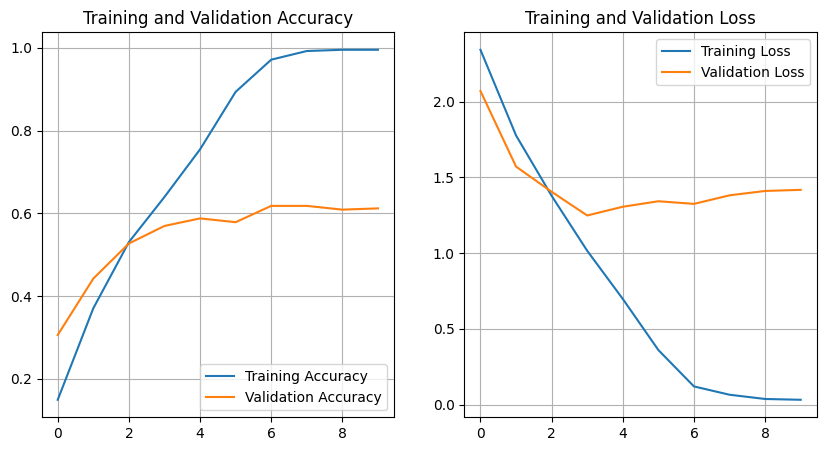

In [ ]:
plot_hist(history)

In [ ]:
# Use the model's evaluate function for direct accuracy measurement
loss, accuracy = model.evaluate(valid_batches)
print("Model Accuracy (evaluate):", accuracy * 100, "%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.6013 - loss: 1.1457
Model Accuracy (evaluate): 56.969696283340454 %


## Transfer learning from EfficientNetB0 + Fine-tuning

this code implements transfer learning. It uses the pre-trained EfficientNetB0 model (trained on ImageNet) as a feature extractor by setting include_top=False, which removes the pre-trained classification head. The base layers are then used to extract features, and new custom layers are added on top for the specific classification task. The model is compiled to fine-tune only the newly added layers initially, leveraging the pre-trained weights for the base model.

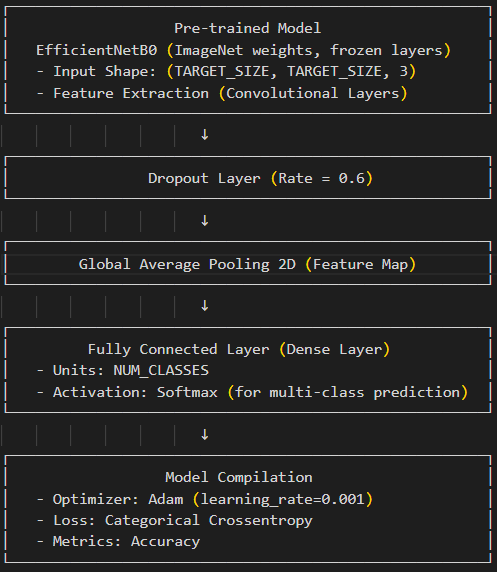

In [ ]:
!pip install --upgrade tensorflow

In [20]:
def create_model():
    conv_base = EfficientNetB0(include_top=False, weights="imagenet",
                               input_shape=(TARGET_SIZE, TARGET_SIZE, 3))

    model = Dropout(0.6)(conv_base.output)
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(NUM_CLASSES, activation="softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = create_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Train the model
epochs = 15
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/15
67/67 - 290s - 4s/step - accuracy: 0.4380 - loss: 1.5934 - val_accuracy: 0.2939 - val_loss: 2.1269 - learning_rate: 0.0010
Epoch 2/15
67/67 - 228s - 3s/step - accuracy: 0.6457 - loss: 1.0481 - val_accuracy: 0.3000 - val_loss: 2.8185 - learning_rate: 0.0010
Epoch 3/15
67/67 - 229s - 3s/step - accuracy: 0.7160 - loss: 0.8371 - val_accuracy: 0.4909 - val_loss: 1.9403 - learning_rate: 0.0010
Epoch 4/15
67/67 - 244s - 4s/step - accuracy: 0.8161 - loss: 0.5548 - val_accuracy: 0.5545 - val_loss: 2.1638 - learning_rate: 0.0010
Epoch 5/15

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
67/67 - 213s - 3s/step - accuracy: 0.8640 - loss: 0.4001 - val_accuracy: 0.5121 - val_loss: 2.4267 - learning_rate: 0.0010
Epoch 6/15
67/67 - 228s - 3s/step - accuracy: 0.9208 - loss: 0.2691 - val_accuracy: 0.6939 - val_loss: 1.1373 - learning_rate: 3.0000e-04
Epoch 7/15
67/67 - 212s - 3s/step - accuracy: 0.9746 - loss: 0.1025 - val_accuracy: 0.7152 - val_loss: 1.0394 - lea

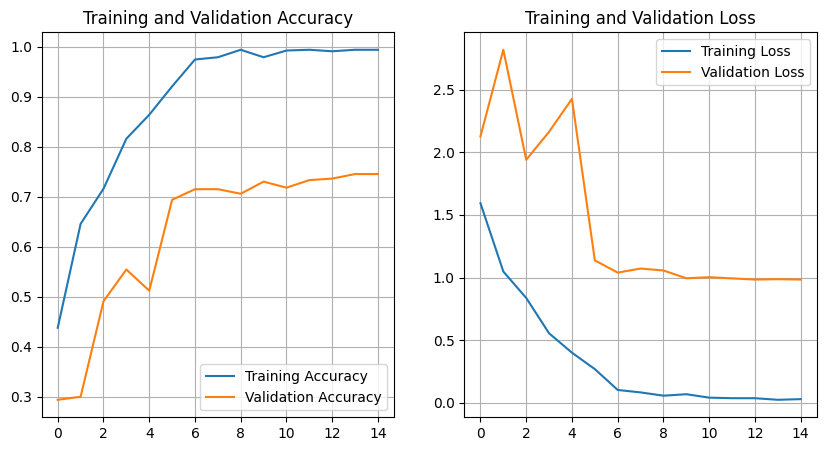

In [22]:
plot_hist(history)

In [22]:
weights_path = './first_finetune_weights.weights.h5'
model.save_weights(weights_path)

In [23]:
# Use the model's evaluate function for direct accuracy measurement
loss, accuracy = model.evaluate(valid_batches)
print("Model Accuracy (evaluate):", accuracy * 100, "%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 718ms/step - accuracy: 0.7463 - loss: 0.8842
Model Accuracy (evaluate): 73.63636493682861 %


In [25]:
result.loc[len(result)] = {'Algos': 'Transfer Learning EfficientNet', 'Accuracy': accuracy}

## Transfer learnening from EfficientNet + Fine-tuning - Unfreese all layers

This code employs transfer learning to classify images by leveraging the pre-trained EfficientNetB0 model, followed by fine-tuning.

Initially, the EfficientNetB0 base is frozen, and only newly added layers are trained: a global average pooling layer, batch normalization, dropout, and a dense output layer with softmax activation. After training with frozen layers for 30 epochs using callbacks, the best weights are saved.

In the second phase, a pre-trained model is finetuned by unfreezing all layers while keeping batch normalization layers frozen for stability.

The model is first cloned and initialized with previously saved weights to ensure a good starting point for fine-tuning.

In the unfreeze_whole_model function, all layers except batch normalization are made trainable to adjust the entire model's parameters to the new dataset.

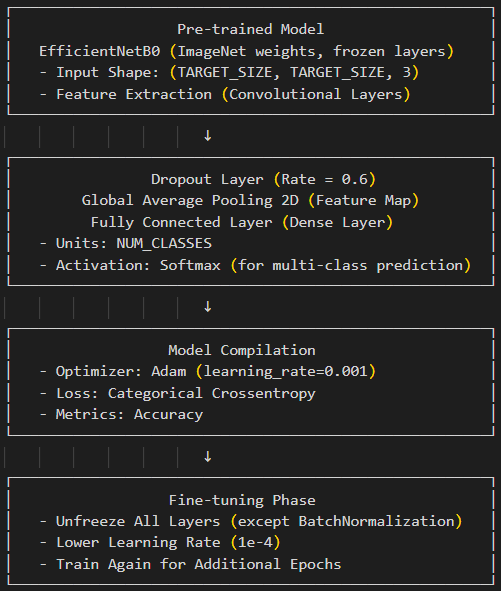

In [23]:
### Unfreeze all layers
cont_model = tf.keras.models.clone_model(model)
cont_model.load_weights(weights_path)

def unfreeze_whole_model(model):
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy",
        metrics=["accuracy"]
    )


unfreeze_whole_model(cont_model)
# cont_model.summary()

In [29]:
epochs = 10  # @param {type: "slider", min:8, max:50}
history = cont_model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs,
  callbacks=[model_save,  reduce_lr],
  verbose=2
)

Epoch 1/10

Epoch 1: val_loss did not improve from 0.97752
67/67 - 230s - 3s/step - accuracy: 0.9910 - loss: 0.0255 - val_accuracy: 0.7030 - val_loss: 1.1188 - learning_rate: 2.7000e-06
Epoch 2/10

Epoch 2: val_loss did not improve from 0.97752
67/67 - 210s - 3s/step - accuracy: 0.9925 - loss: 0.0388 - val_accuracy: 0.7242 - val_loss: 1.0328 - learning_rate: 2.7000e-06
Epoch 3/10

Epoch 3: val_loss did not improve from 0.97752
67/67 - 269s - 4s/step - accuracy: 0.9940 - loss: 0.0338 - val_accuracy: 0.7394 - val_loss: 1.0037 - learning_rate: 2.7000e-06
Epoch 4/10

Epoch 4: val_loss did not improve from 0.97752
67/67 - 209s - 3s/step - accuracy: 0.9955 - loss: 0.0223 - val_accuracy: 0.7394 - val_loss: 0.9961 - learning_rate: 2.7000e-06
Epoch 5/10

Epoch 5: val_loss did not improve from 0.97752
67/67 - 265s - 4s/step - accuracy: 0.9970 - loss: 0.0270 - val_accuracy: 0.7364 - val_loss: 1.0002 - learning_rate: 2.7000e-06
Epoch 6/10

Epoch 6: val_loss did not improve from 0.97752

Epoch 6: R

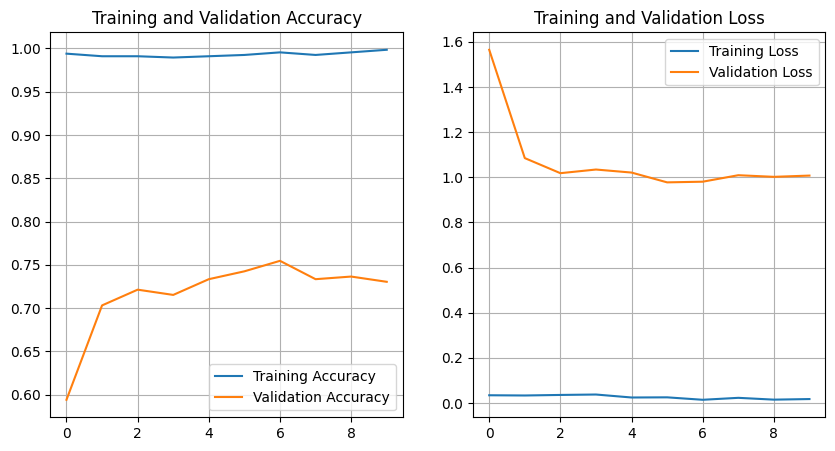

In [25]:
plot_hist(history)

In [30]:
# Use the model's evaluate function for direct accuracy measurement
loss, accuracy = cont_model.evaluate(valid_batches)
print("Model Accuracy (evaluate):", accuracy * 100, "%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 609ms/step - accuracy: 0.7667 - loss: 0.9614
Model Accuracy (evaluate): 73.9393949508667 %


# Transformers

Code source: [Music Genre Classification with DistilHubert](https://github.com/mahimairaja/music-genre-gtzan-classification/blob/main/Notebooks/music_genre_classification_with_distilbert.ipynb)

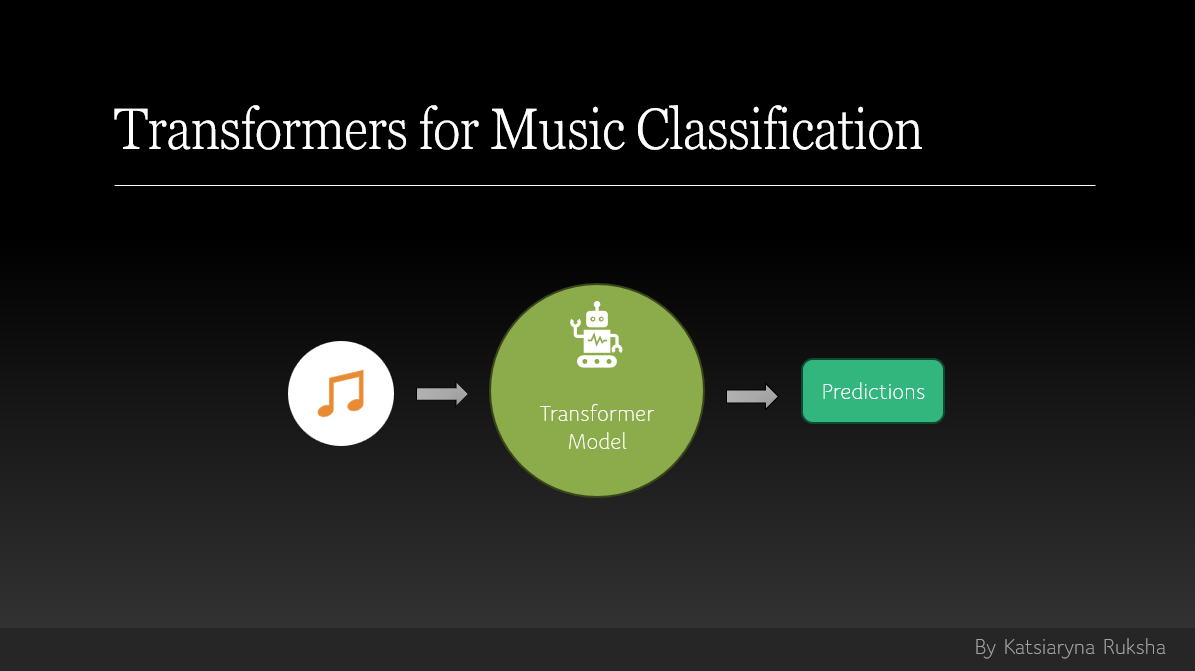

This code handles preprocessing of audio files for training a machine learning model. It first initializes a feature extractor (feature_extractor) from a pre-trained model to prepare audio data for input. The expected sampling rate and maximum audio duration are defined to standardize and truncate audio files appropriately.


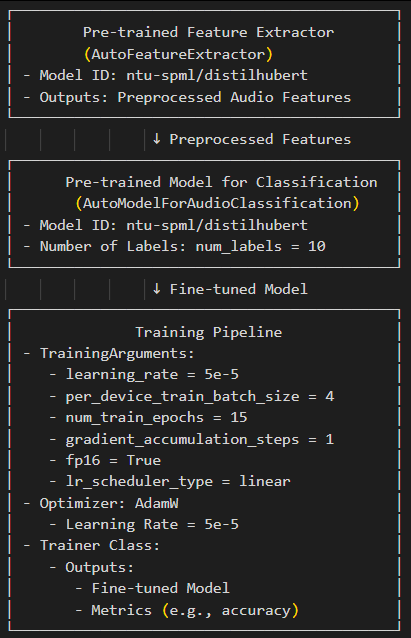

In [ ]:
# Loading the feature extractor for our model
model_id = "ntu-spml/distilhubert"

feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)
sampling_rate = feature_extractor.sampling_rate

In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)
sampling_rate = feature_extractor.sampling_rate
max_duration = 3.0  # Maximum duration in seconds for truncation

# Load audio files and resample if needed
def load_audio(file_list):
    audio_data = []
    genres = []
    for file in file_list:
        try:
            waveform, sr = torchaudio.load(file)
            genres.append(os.path.split(os.path.dirname(file))[-1])
        except:
            print("Error while reading ", file)
            continue
        # Resample to match the model's expected sampling rate
        if sr != sampling_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sampling_rate)
            waveform = resampler(waveform)
        audio_data.append({"audio": waveform.squeeze(0).numpy(), "file": file})
    return Dataset.from_list(audio_data), genres

# Preprocessing function for the audio data
def preprocess_function(examples):
    audio_arrays = examples["audio"]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=sampling_rate,
        max_length=int(sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [11]:
train_dataset, train_labels = load_audio(filenames_train)
# Preprocess the datasets
train_encoded = train_dataset.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1
)
print(f"Processed train dataset size: {len(train_encoded)}")

Error while reading  Data/genres_original/jazz/jazz.00054.wav


Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Processed train dataset size: 669


In [12]:
unique_labels = sorted(set(list(train_labels)))

# Map indices to labels
id2label = {str(i): label for i, label in enumerate(unique_labels)}
label2id = {label: str(i) for i, label in enumerate(unique_labels)}

# Print the mappings
print("ID to Label Mapping:")
print(id2label)
print("\nLabel to ID Mapping:")
print(label2id)

ID to Label Mapping:
{'0': 'blues', '1': 'classical', '2': 'country', '3': 'disco', '4': 'hiphop', '5': 'jazz', '6': 'metal', '7': 'pop', '8': 'reggae', '9': 'rock'}

Label to ID Mapping:
{'blues': '0', 'classical': '1', 'country': '2', 'disco': '3', 'hiphop': '4', 'jazz': '5', 'metal': '6', 'pop': '7', 'reggae': '8', 'rock': '9'}


In [13]:
y_train_id = [int(label2id[label]) for label in train_labels]
train_encoded = train_encoded.add_column("label", y_train_id)
import pickle
with open('train_encoded_with_labels.pkl', 'wb') as f:
    pickle.dump(train_encoded, f)

In [9]:
test_dataset, test_labels = load_audio(filenames_test)


test_encoded = test_dataset.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
print(f"Processed test dataset size: {len(test_encoded)}")

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Processed test dataset size: 330


In [10]:
unique_labels = sorted(set(list(test_labels)))

# Map indices to labels
id2label = {str(i): label for i, label in enumerate(unique_labels)}
label2id = {label: str(i) for i, label in enumerate(unique_labels)}

# Print the mappings
print("ID to Label Mapping:")
print(id2label)
print("\nLabel to ID Mapping:")
print(label2id)

ID to Label Mapping:
{'0': 'blues', '1': 'classical', '2': 'country', '3': 'disco', '4': 'hiphop', '5': 'jazz', '6': 'metal', '7': 'pop', '8': 'reggae', '9': 'rock'}

Label to ID Mapping:
{'blues': '0', 'classical': '1', 'country': '2', 'disco': '3', 'hiphop': '4', 'jazz': '5', 'metal': '6', 'pop': '7', 'reggae': '8', 'rock': '9'}


In [14]:
import pickle
y_test_id = [int(label2id[label]) for label in test_labels]
# Add labels to the datasets
test_encoded = test_encoded.add_column("label", y_test_id)

with open('test_encoded_with_labels.pkl', 'wb') as f:
    pickle.dump(test_encoded, f)

In [21]:
import pickle
with open('train_encoded_with_labels.pkl', 'rb') as f:
    train_encoded = pickle.load(f)

with open('test_encoded_with_labels.pkl', 'rb') as f:
    test_encoded = pickle.load(f)

In [22]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
batch_size = 4
gradient_accumulation_steps = 1
num_train_epochs = 15

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=42,
    fp16=True,
    lr_scheduler_type="linear",
    push_to_hub=False,
    output_dir='Data'
)

# Define the optimizer separately
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)


In [26]:
# Defining the evaluation metrics

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [31]:
# Let's start training for fine-tuning
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_encoded,
    eval_dataset=test_encoded,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,2.119600,2.090459,0.396970
2,1.770900,1.698315,0.481818
3,1.336600,1.254191,0.606061
4,0.888400,1.087675,0.666667
5,0.521300,1.159298,0.609091
6,0.452600,1.166464,0.651515
7,0.270700,1.206463,0.663636
8,0.043700,1.238754,0.684848
9,0.020900,1.440993,0.669697
10,0.010800,1.484717,0.696970


TrainOutput(global_step=2520, training_loss=0.5306680107873584, metrics={'train_runtime': 1046.9382, 'train_samples_per_second': 9.585, 'train_steps_per_second': 2.407, 'total_flos': 6.847004709216e+16, 'train_loss': 0.5306680107873584, 'epoch': 15.0})

In [1]:
# Use the model's evaluate function for direct accuracy measurement
loss, accuracy = trainer.evaluate(test_encoded)
result.loc[len(result)] = {'Algos': 'DistilHubert Finetuned', 'Accuracy': accuracy}
print("Model Accuracy (evaluate):", accuracy * 100, "%")

Model Accuracy (evaluate): 70.0 %


# Results

In [3]:
result.sort_values('Accuracy',ascending=False)

,Algos,Accuracy
1,LightGBM,0.790909
2,RandomForestClassifier,0.778788
3,XGBClassifier,0.769697
4,NeuralNetwork,0.769697
9,Transfer Learning EfficientNet (Unfreeze all),0.739394
10,Transfer Learning EfficientNet,0.736364
5,LogisticRegression,0.730303
0,DistilHubert Finetuned,0.700000
6,KNeighborsClassifier,0.690909
8,CNN,0.569690
